In [ ]:
import sys

sys.path.append("..")

from utilities import *
from catboost import CatBoostRegressor  

warnings.filterwarnings("ignore")

raw_data = pd.read_excel("../data/Datos_Market_copy.xlsx")

sa = SalesAnalysis(raw_data)

data = sa.data

data = data[
    data["brand"].isin(["brand-35", "brand-14", "brand-15"])
] # Filtramos las 3 brands principales únicamente

print(f"Datos cargados: {len(data)} filas")
print(f"Rango de fechas: {data['date'].min()} a {data['date'].max()}")


Datos cargados: 4306 filas
Rango de fechas: 2021-01-31 a 2023-12-31
Marcas disponibles: ['brand-14', 'brand-15', 'brand-35', 'other']
Supermercados disponibles: ['supermarket-A', 'supermarket-B', 'supermarket-C', 'supermarket-D']
Número de combinaciones únicas (brand + supermarket + variant + pack_size): 143


In [115]:
# ============================================================================
# PASO 1: Preparación de datos y creación de series_id
# ============================================================================

# Convertir date a datetime si no lo está
data['date'] = pd.to_datetime(data['date'])

# Crear series_id combinando brand + supermarket + variant + pack_size
data['series_id'] = (
    data['brand'].astype(str) + '_' + 
    data['supermarket'].astype(str) + '_' + 
    data['variant'].astype(str) + '_' + 
    data['pack.size'].astype(str)
)

# Ordenar por series_id y date
data = data.sort_values(['series_id', 'date']).reset_index(drop=True)

print(f"Número de series únicas: {data['series_id'].nunique()}")
print(f"Series ID ejemplo: {data['series_id'].iloc[0]}")


Número de series únicas: 143
Series ID ejemplo: brand-14_supermarket-A_flavoured_0 - 350 GR


In [116]:
# ============================================================================
# PASO 2: Construcción del dataset de forecasting
# ============================================================================

# Variables temporales
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Lags del target (por series_id) - CRÍTICO: agrupar por series_id
data['lag_1'] = data.groupby('series_id')['volume.sales'].shift(1)
data['lag_2'] = data.groupby('series_id')['volume.sales'].shift(2)
data['lag_3'] = data.groupby('series_id')['volume.sales'].shift(3)
data['lag_12'] = data.groupby('series_id')['volume.sales'].shift(12)

# Rolling means - CRÍTICO: usar shift(1) antes de rolling para evitar leakage
# Primero hacer shift(1) por grupo, luego aplicar rolling dentro de cada grupo
data['volume_sales_shifted'] = data.groupby('series_id')['volume.sales'].shift(1)
data['rolling_mean_3'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_mean_6'] = data.groupby('series_id')['volume_sales_shifted'].rolling(window=6, min_periods=1).mean().reset_index(0, drop=True)
data = data.drop(columns=['volume_sales_shifted'])  # Eliminar columna temporal

# Variables de precio
data['price_lag_1'] = data.groupby('series_id')['price'].shift(1)
data['price_lag_12'] = data.groupby('series_id')['price'].shift(12)

# Renombrar pack.size para consistencia
data['pack_size'] = data['pack.size']

print("Features creadas:")
print(f"  - Lags: lag_1, lag_2, lag_3, lag_12")
print(f"  - Rolling means: rolling_mean_3, rolling_mean_6")
print(f"  - Precio: price, price_lag_1, price_lag_12")
print(f"  - Temporales: month, year")
print(f"  - Categóricas: brand, supermarket, variant, pack_size")


Features creadas:
  - Lags: lag_1, lag_2, lag_3, lag_12
  - Rolling means: rolling_mean_3, rolling_mean_6
  - Precio: price, price_lag_1, price_lag_12
  - Temporales: month, year
  - Categóricas: brand, supermarket, variant, pack_size


In [117]:
# ============================================================================
# PASO 3: Transformación del target y preparación para modelado
# ============================================================================

# Transformar target con log1p
data['target_log'] = np.log1p(data['volume.sales'])

# Seleccionar columnas para el modelo
feature_cols = [
    'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_12',
    'rolling_mean_3', 'rolling_mean_6',
    'price', 'price_lag_1', 'price_lag_12',
    'brand', 'supermarket', 'variant', 'pack_size'
]

categorical_features = ['brand', 'supermarket', 'variant', 'pack_size']

print(f"Features seleccionadas: {len(feature_cols)}")
print(f"Features categóricas: {categorical_features}")


Features seleccionadas: 15
Features categóricas: ['brand', 'supermarket', 'variant', 'pack_size']


In [118]:
# ============================================================================
# PASO 4: Split temporal explícito
# CRÍTICO: Fijar fechas explícitamente para evitar que se mueva el split
# ============================================================================

# Fijar fechas explícitamente
train_cutoff = pd.Timestamp('2023-06-30')
test_start = pd.Timestamp('2023-07-01')
test_end = pd.Timestamp('2023-12-31')

train_data = data[data['date'] <= train_cutoff].copy()
test_data = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()

print(f"Train: {len(train_data)} filas, desde {train_data['date'].min()} hasta {train_data['date'].max()}")
print(f"Test: {len(test_data)} filas, desde {test_data['date'].min()} hasta {test_data['date'].max()}")


Train: 3579 filas, desde 2021-01-31 00:00:00 hasta 2023-06-30 00:00:00
Test: 727 filas, desde 2023-07-31 00:00:00 hasta 2023-12-31 00:00:00


In [119]:
# ============================================================================
# PASO 5: Manejo de NaNs por lags
# CRÍTICO: Eliminar filas donde lag_12 es NaN antes de entrenar
# ============================================================================

# Eliminar filas con lag_12 NaN (opción simple recomendada)
train_data_clean = train_data.dropna(subset=['lag_12']).copy()
test_data_clean = test_data.dropna(subset=['lag_12']).copy()

print(f"Train después de eliminar NaNs de lag_12: {len(train_data_clean)} filas (se perdieron {len(train_data) - len(train_data_clean)} filas)")
print(f"Test después de eliminar NaNs de lag_12: {len(test_data_clean)} filas (se perdieron {len(test_data) - len(test_data_clean)} filas)")

# Verificar que no haya más NaNs en las features
print(f"\nNaNs en train_data_clean:")
print(train_data_clean[feature_cols].isnull().sum())

# Si hay NaNs en otras features, eliminarlos también
train_data_clean = train_data_clean.dropna(subset=feature_cols + ['target_log'])
test_data_clean = test_data_clean.dropna(subset=feature_cols + ['target_log'])

print(f"\nTrain final: {len(train_data_clean)} filas")
print(f"Test final: {len(test_data_clean)} filas")


Train después de eliminar NaNs de lag_12: 1968 filas (se perdieron 1611 filas)
Test después de eliminar NaNs de lag_12: 672 filas (se perdieron 55 filas)

NaNs en train_data_clean:
month             0
year              0
lag_1             0
lag_2             0
lag_3             0
lag_12            0
rolling_mean_3    0
rolling_mean_6    0
price             0
price_lag_1       0
price_lag_12      0
brand             0
supermarket       0
variant           0
pack_size         0
dtype: int64

Train final: 1968 filas
Test final: 672 filas


In [120]:
# ============================================================================
# PASO 6: Preparar datos para CatBoost
# ============================================================================

# Separar features y target
X_train = train_data_clean[feature_cols].copy()
y_train = train_data_clean['target_log'].copy()

X_test = test_data_clean[feature_cols].copy()
y_test = test_data_clean['target_log'].copy()

# Guardar valores originales para métricas
y_test_original = test_data_clean['volume.sales'].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (1968, 15)
X_test shape: (672, 15)


In [121]:
# ============================================================================
# PASO 7: Entrenamiento del modelo CatBoost
# ============================================================================

# Obtener índices de features categóricas
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in X_train.columns]

# Configurar CatBoost
model = CatBoostRegressor(
    loss_function='MAE',
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
    cat_features=cat_indices
)

# Entrenar modelo
print("Entrenando modelo CatBoost...")
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,
    verbose=100
)

print("Modelo entrenado exitosamente!")


Entrenando modelo CatBoost...
0:	learn: 1.6450490	test: 1.7225791	best: 1.7225791 (0)	total: 1.4ms	remaining: 699ms
100:	learn: 0.3531596	test: 0.4187961	best: 0.4187961 (100)	total: 145ms	remaining: 574ms
200:	learn: 0.2832782	test: 0.4078447	best: 0.4053813 (166)	total: 294ms	remaining: 437ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4053813324
bestIteration = 166

Shrink model to first 167 iterations.
Modelo entrenado exitosamente!


In [122]:
# ============================================================================
# PASO 8: Evaluación del modelo
# ============================================================================

# Predicciones en escala log
y_pred_log = model.predict(X_test)

# Transformar de vuelta a escala original
y_pred = np.expm1(y_pred_log)
y_test_vals = y_test_original.values

# Funciones para calcular métricas
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / (denominator + 1e-9)) * 100

def wape(y_true, y_pred):
    """Weighted Absolute Percentage Error"""
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    return (numerator / (denominator + 1e-9)) * 100

# Calcular métricas
mae = mean_absolute_error(y_test_vals, y_pred)
smape_val = smape(y_test_vals, y_pred)
wape_val = wape(y_test_vals, y_pred)

print("=" * 60)
print("MÉTRICAS EN TEST SET (agregadas)")
print("=" * 60)
print(f"MAE:  {mae:.4f}")
print(f"sMAPE: {smape_val:.4f}%")
print(f"WAPE: {wape_val:.4f}%")
print("=" * 60)


MÉTRICAS EN TEST SET (agregadas)
MAE:  8686.2781
sMAPE: 36.5844%
WAPE: 25.6861%


In [123]:
# ============================================================================
# PASO 9: Métricas por serie
# ============================================================================

# Agregar predicciones al test_data_clean
test_data_clean = test_data_clean.copy()
test_data_clean['prediction'] = y_pred
test_data_clean['prediction_log'] = y_pred_log

# Calcular métricas por serie
metrics_by_series = []

for series_id in test_data_clean['series_id'].unique():
    series_data = test_data_clean[test_data_clean['series_id'] == series_id]
    
    if len(series_data) == 0:
        continue
    
    y_true_series = series_data['volume.sales'].values
    y_pred_series = series_data['prediction'].values
    
    mae_series = mean_absolute_error(y_true_series, y_pred_series)
    smape_series = smape(y_true_series, y_pred_series)
    wape_series = wape(y_true_series, y_pred_series)
    
    metrics_by_series.append({
        'series_id': series_id,
        'n_observations': len(series_data),
        'MAE': mae_series,
        'sMAPE_%': smape_series,
        'WAPE_%': wape_series
    })

metrics_df = pd.DataFrame(metrics_by_series)
metrics_df = metrics_df.sort_values('MAE')

print("\nTop 10 series con mejor MAE:")
print(metrics_df.head(10).to_string(index=False))

print("\nTop 10 series con peor MAE:")
print(metrics_df.tail(10).to_string(index=False))

print(f"\nResumen estadístico de métricas por serie:")
print(metrics_df[['MAE', 'sMAPE_%', 'WAPE_%']].describe())



Top 10 series con mejor MAE:
                                   series_id  n_observations      MAE    sMAPE_%      WAPE_%
     brand-15_supermarket-D_light_0 - 350 GR               1 0.098691  32.968961   39.476448
   brand-14_supermarket-D_light_351 - 500 GR               2 0.328850 172.352609   95.318700
  brand-35_supermarket-B_standard_0 - 350 GR               2 0.592078 128.216216  358.835178
brand-14_supermarket-D_standard_351 - 500 GR               1 1.122461 117.383927  284.167285
   brand-14_supermarket-C_light_351 - 500 GR               2 1.173189 127.687627  340.054873
    other_supermarket-B_standard_450 - 600GR               3 2.254190  64.698754   58.804957
     brand-14_supermarket-B_light_0 - 350 GR               5 3.886186  76.411143  162.465984
  brand-14_supermarket-B_standard_0 - 350 GR               5 6.265997 107.722423  177.708370
   other_supermarket-D_standard_501 - 700 GR               2 7.258015  73.095445  121.983438
  brand-14_supermarket-D_standard_0 - 35

In [125]:
# ============================================================================
# PASO 10: Predicciones futuras (método recursivo)
# CRÍTICO: Usar método recursivo donde predicciones previas se usan como lags
# ============================================================================

def generate_future_predictions(model, last_data, horizon=6, price_scenario='same'):
    """
    Genera predicciones futuras usando método recursivo.
    
    Parameters:
    -----------
    model: CatBoostRegressor entrenado
    last_data: DataFrame con los últimos datos conocidos (debe tener todas las features)
    horizon: número de meses a predecir
    price_scenario: 'same', 'plus3', 'minus3'
    
    Returns:
    --------
    DataFrame con predicciones futuras
    """
    # Obtener el último mes conocido para cada serie
    last_by_series = last_data.groupby('series_id').tail(1).copy()
    
    # Crear estructura para almacenar predicciones
    future_predictions = []
    
    for series_id in last_by_series['series_id'].unique():
        series_last = last_by_series[last_by_series['series_id'] == series_id].iloc[0]
        
        # Obtener historial de la serie (últimos 12 meses para lags)
        series_history = last_data[last_data['series_id'] == series_id].sort_values('date').tail(12).copy()
        
        # Inicializar valores para predicción recursiva
        current_lags = {
            'lag_1': series_last['volume.sales'] if not pd.isna(series_last['volume.sales']) else series_history['volume.sales'].iloc[-1] if len(series_history) > 0 else 0,
            'lag_2': series_history['volume.sales'].iloc[-2] if len(series_history) >= 2 else series_history['volume.sales'].iloc[-1] if len(series_history) > 0 else 0,
            'lag_3': series_history['volume.sales'].iloc[-3] if len(series_history) >= 3 else series_history['volume.sales'].iloc[-1] if len(series_history) > 0 else 0,
            'lag_12': series_history['volume.sales'].iloc[-12] if len(series_history) >= 12 else series_history['volume.sales'].iloc[-1] if len(series_history) > 0 else 0,
        }
        
        # Precio base
        base_price = series_last['price']
        price_history = series_history['price'].values.tolist() if len(series_history) > 0 else [base_price]
        
        # Última fecha conocida
        last_date = pd.to_datetime(series_last['date'])
        
        # Historial para rolling means (solo valores reales inicialmente)
        volume_history = series_history['volume.sales'].values.tolist()
        
        # Precio lag_1 inicial
        current_price_lag_1 = base_price
        
        # Generar predicciones mes a mes
        for step in range(1, horizon + 1):
            future_date = last_date + pd.DateOffset(months=step)
            
            # Determinar precio futuro según escenario
            if price_scenario == 'plus3':
                future_price = base_price * 1.03
            elif price_scenario == 'minus3':
                future_price = base_price * 0.97
            else:
                future_price = base_price
            
            # Calcular rolling means (usando shift(1) conceptualmente - solo valores pasados)
            # Para rolling_mean_3, usar los últimos 3 valores del historial (sin incluir predicción actual)
            if len(volume_history) >= 3:
                rolling_mean_3 = np.mean(volume_history[-3:])
            else:
                rolling_mean_3 = np.mean(volume_history) if len(volume_history) > 0 else current_lags['lag_1']
            
            if len(volume_history) >= 6:
                rolling_mean_6 = np.mean(volume_history[-6:])
            else:
                rolling_mean_6 = np.mean(volume_history) if len(volume_history) > 0 else current_lags['lag_1']
            
            # Precio lag_12 (del historial real)
            price_lag_12_val = series_history['price'].iloc[-12] if len(series_history) >= 12 else base_price
            
            # Crear fila de features para predicción
            features_row = pd.DataFrame({
                'month': [future_date.month],
                'year': [future_date.year],
                'lag_1': [current_lags['lag_1']],
                'lag_2': [current_lags['lag_2']],
                'lag_3': [current_lags['lag_3']],
                'lag_12': [current_lags['lag_12']],
                'rolling_mean_3': [rolling_mean_3],
                'rolling_mean_6': [rolling_mean_6],
                'price': [future_price],
                'price_lag_1': [current_price_lag_1],
                'price_lag_12': [price_lag_12_val],
                'brand': [series_last['brand']],
                'supermarket': [series_last['supermarket']],
                'variant': [series_last['variant']],
                'pack_size': [series_last['pack_size']]
            })
            
            # Predecir en escala log
            pred_log = model.predict(features_row[feature_cols])[0]
            
            # Transformar a escala original
            pred_original = np.expm1(pred_log)
            
            # Guardar predicción
            future_predictions.append({
                'series_id': series_id,
                'date': future_date,
                'prediction_log': pred_log,
                'prediction': pred_original,
                'price_scenario': price_scenario,
                'month': future_date.month,
                'year': future_date.year
            })
            
            # Actualizar para siguiente iteración (método recursivo)
            volume_history.append(pred_original)
            price_history.append(future_price)
            
            # Actualizar lags: lag_3 toma el valor de lag_2, lag_2 toma el de lag_1, lag_1 toma la nueva predicción
            current_lags['lag_3'] = current_lags['lag_2']
            current_lags['lag_2'] = current_lags['lag_1']
            current_lags['lag_1'] = pred_original
            # lag_12 se mantiene igual (estacionalidad)
            
            # Actualizar price_lag_1 para siguiente iteración
            current_price_lag_1 = future_price
    
    return pd.DataFrame(future_predictions)

# Obtener datos hasta el final del test set para usar como base
data_for_forecast = pd.concat([train_data_clean, test_data_clean]).sort_values(['series_id', 'date'])

# Generar predicciones para los 3 escenarios
print("Generando predicciones futuras (6 meses)...")
print("Escenario: mismo precio")
forecast_same = generate_future_predictions(model, data_for_forecast, horizon=6, price_scenario='same')

print("Escenario: precio +3%")
forecast_plus3 = generate_future_predictions(model, data_for_forecast, horizon=6, price_scenario='plus3')

print("Escenario: precio -3%")
forecast_minus3 = generate_future_predictions(model, data_for_forecast, horizon=6, price_scenario='minus3')

print(f"\nPredicciones generadas:")
print(f"  - Escenario mismo precio: {len(forecast_same)} predicciones")
print(f"  - Escenario +3%: {len(forecast_plus3)} predicciones")
print(f"  - Escenario -3%: {len(forecast_minus3)} predicciones")


Generando predicciones futuras (6 meses)...
Escenario: mismo precio
Escenario: precio +3%
Escenario: precio -3%

Predicciones generadas:
  - Escenario mismo precio: 774 predicciones
  - Escenario +3%: 774 predicciones
  - Escenario -3%: 774 predicciones


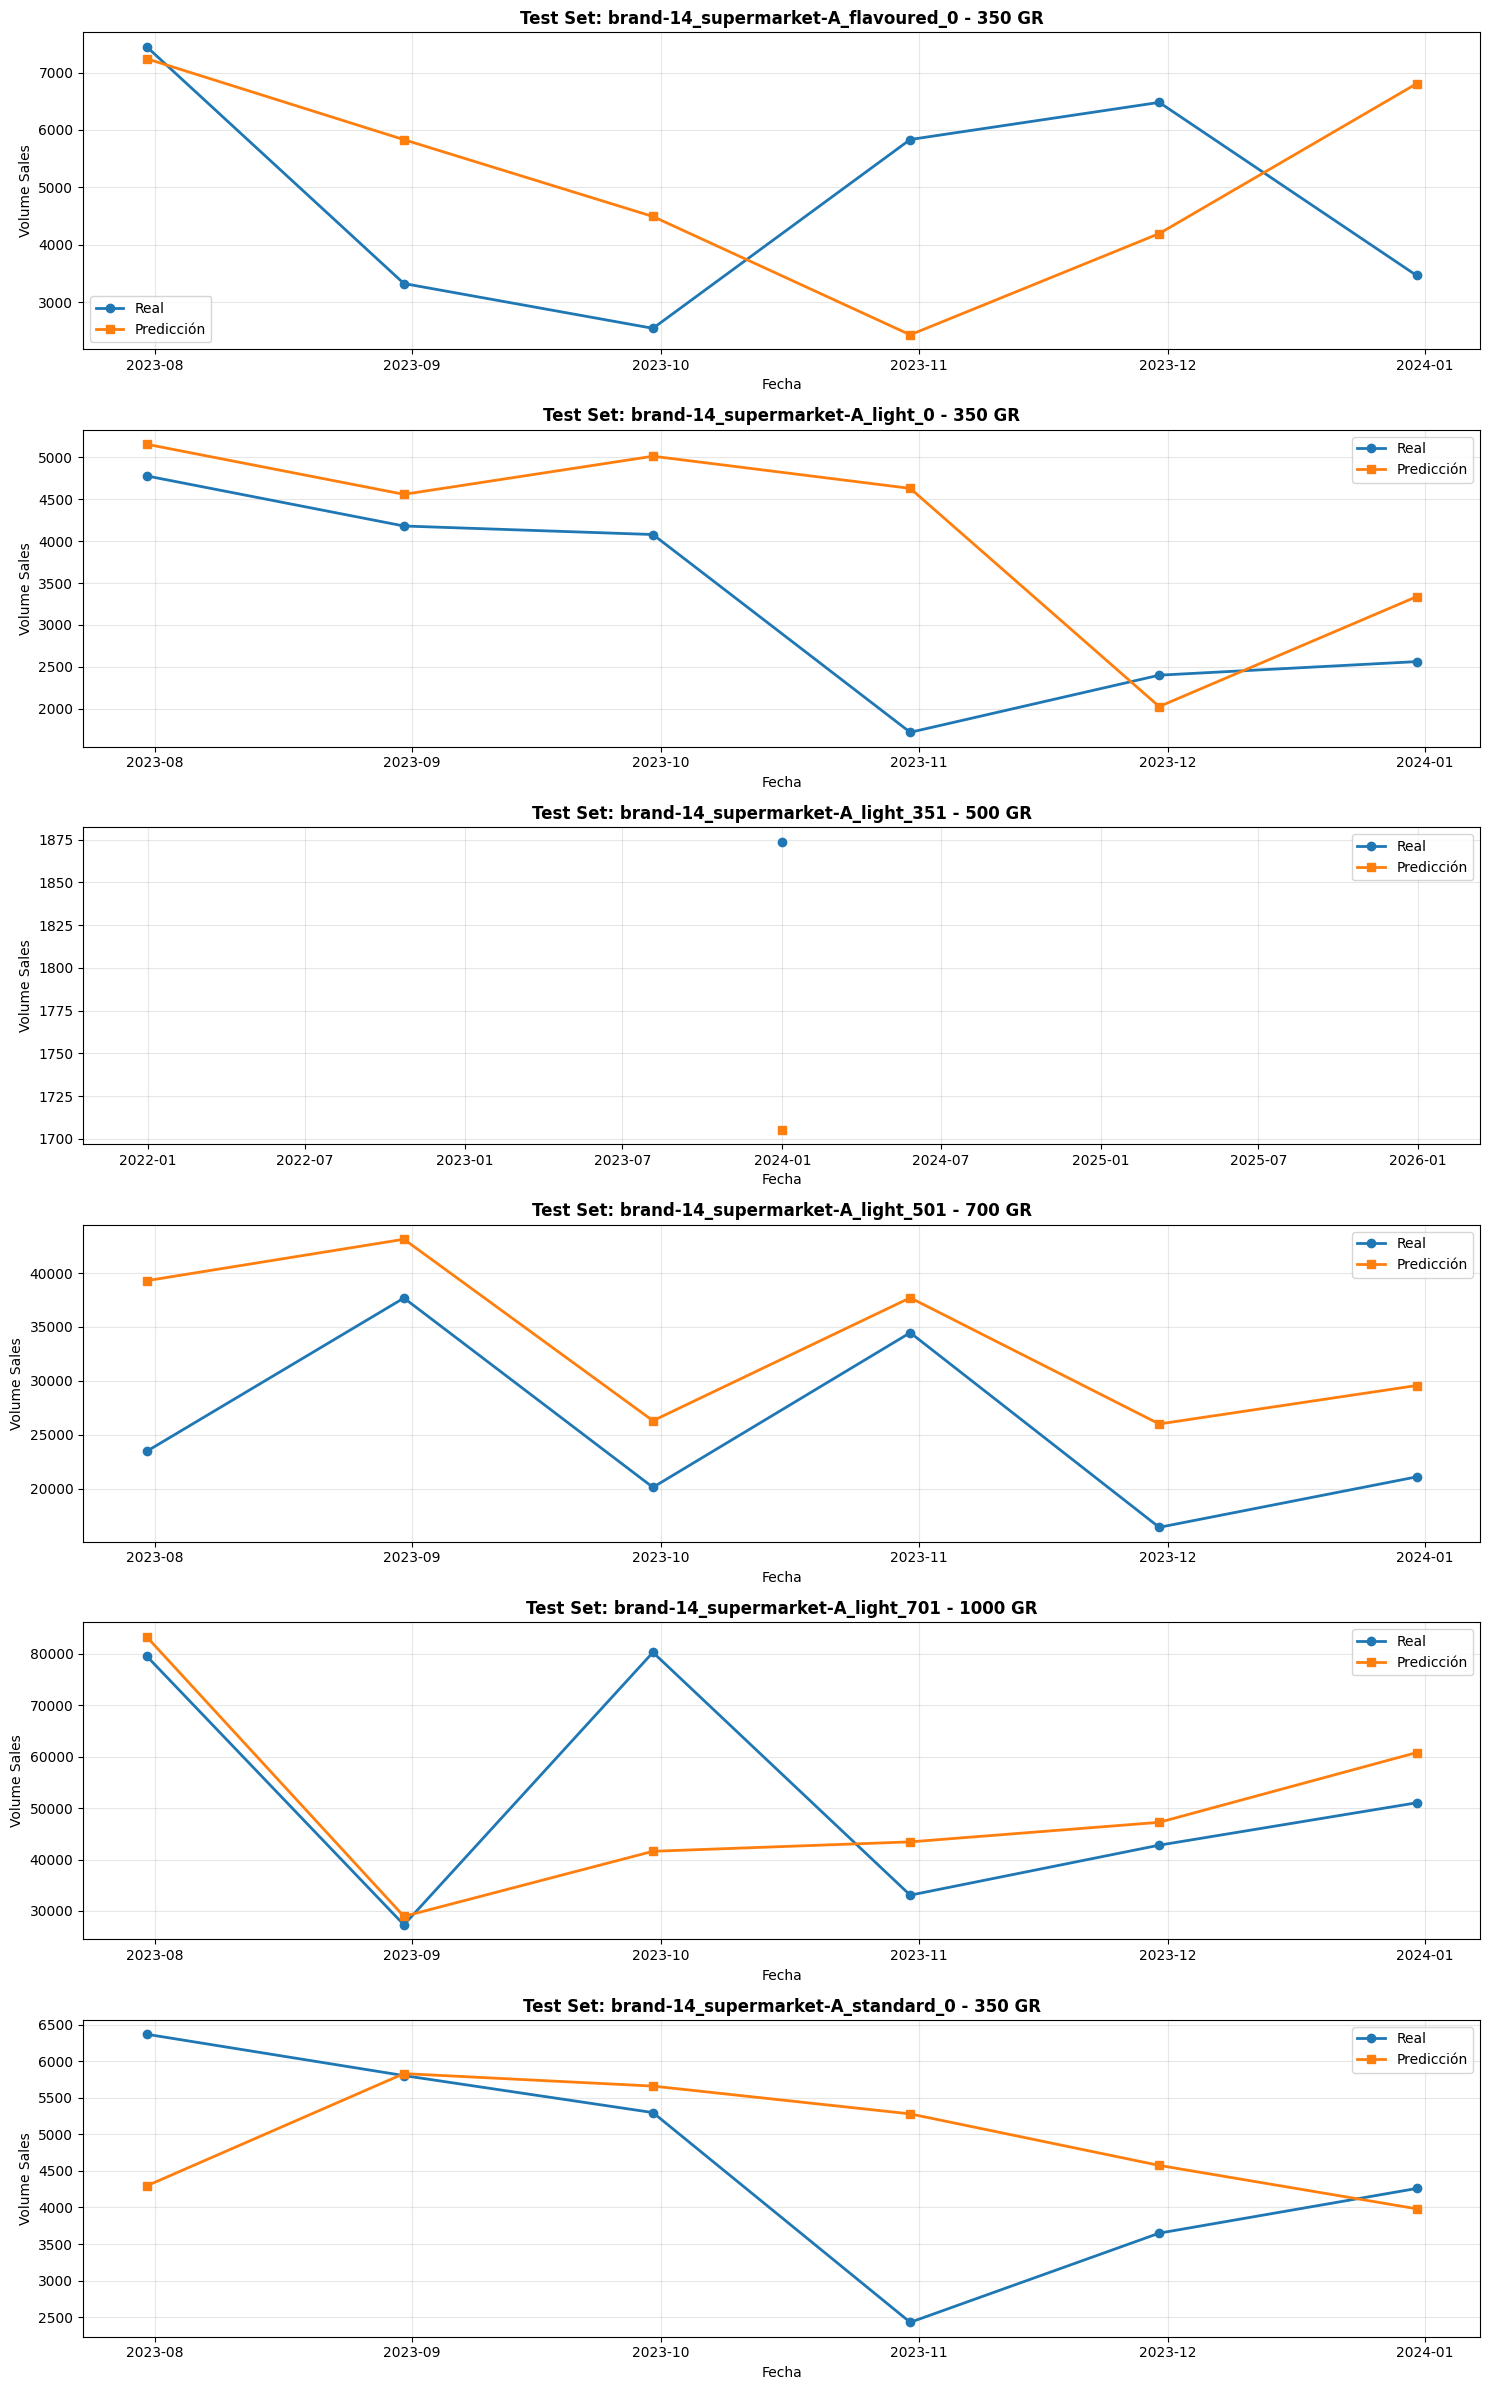

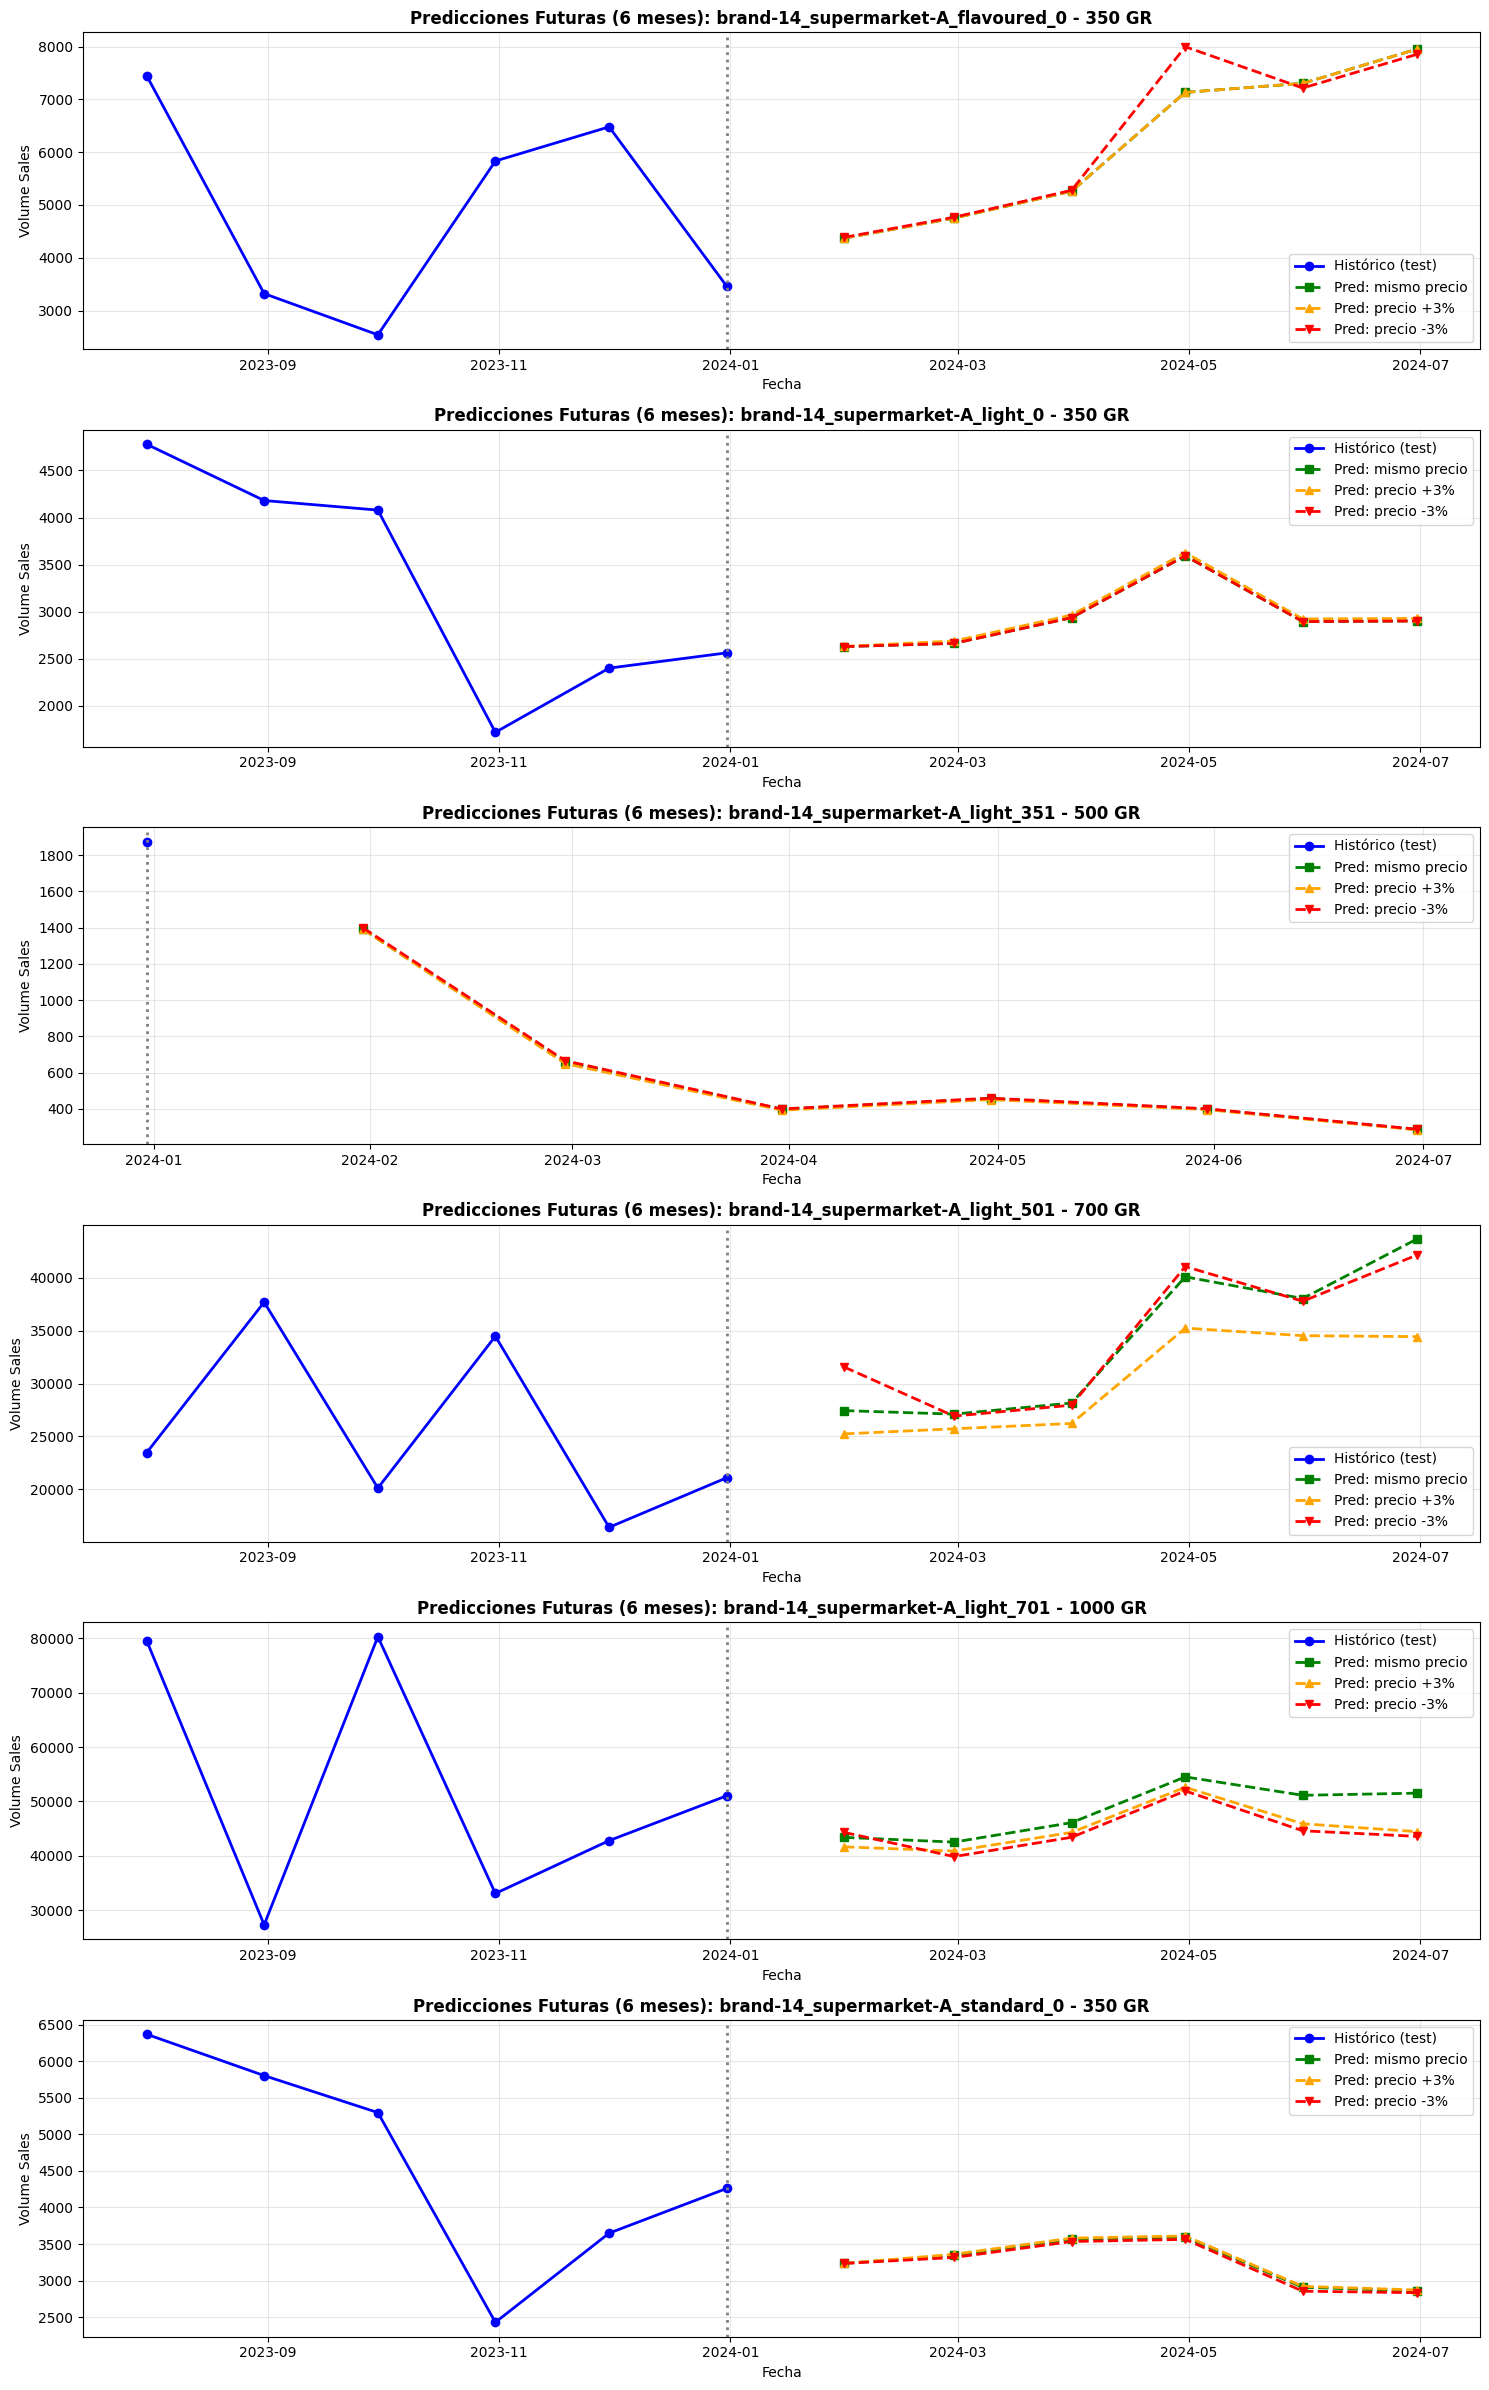

In [126]:
# ============================================================================
# PASO 11: Visualizaciones
# ============================================================================

import matplotlib.pyplot as plt

# 1. Gráfico de predicciones vs valores reales (test set) - algunas series ejemplo
n_series_to_plot = min(6, test_data_clean['series_id'].nunique())
example_series = test_data_clean['series_id'].unique()[:n_series_to_plot]

fig, axes = plt.subplots(n_series_to_plot, 1, figsize=(15, 4 * n_series_to_plot))
if n_series_to_plot == 1:
    axes = [axes]

for idx, series_id in enumerate(example_series):
    series_data = test_data_clean[test_data_clean['series_id'] == series_id].sort_values('date')
    
    axes[idx].plot(series_data['date'], series_data['volume.sales'], 'o-', label='Real', linewidth=2, markersize=6)
    axes[idx].plot(series_data['date'], series_data['prediction'], 's-', label='Predicción', linewidth=2, markersize=6)
    axes[idx].set_title(f'Test Set: {series_id}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Fecha')
    axes[idx].set_ylabel('Volume Sales')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Gráfico de predicciones futuras con los 3 escenarios - algunas series ejemplo
fig, axes = plt.subplots(n_series_to_plot, 1, figsize=(15, 4 * n_series_to_plot))
if n_series_to_plot == 1:
    axes = [axes]

for idx, series_id in enumerate(example_series):
    # Datos históricos (últimos 6 meses del test)
    historical = test_data_clean[test_data_clean['series_id'] == series_id].sort_values('date').tail(6)
    
    # Predicciones futuras
    future_same = forecast_same[forecast_same['series_id'] == series_id].sort_values('date')
    future_plus3 = forecast_plus3[forecast_plus3['series_id'] == series_id].sort_values('date')
    future_minus3 = forecast_minus3[forecast_minus3['series_id'] == series_id].sort_values('date')
    
    axes[idx].plot(historical['date'], historical['volume.sales'], 'o-', label='Histórico (test)', 
                   linewidth=2, markersize=6, color='blue')
    axes[idx].plot(future_same['date'], future_same['prediction'], 's--', label='Pred: mismo precio', 
                   linewidth=2, markersize=6, color='green')
    axes[idx].plot(future_plus3['date'], future_plus3['prediction'], '^--', label='Pred: precio +3%', 
                   linewidth=2, markersize=6, color='orange')
    axes[idx].plot(future_minus3['date'], future_minus3['prediction'], 'v--', label='Pred: precio -3%', 
                   linewidth=2, markersize=6, color='red')
    axes[idx].set_title(f'Predicciones Futuras (6 meses): {series_id}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Fecha')
    axes[idx].set_ylabel('Volume Sales')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axvline(x=historical['date'].max(), color='gray', linestyle=':', linewidth=2, label='Inicio predicción')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# PASO 12: Guardar resultados
# ============================================================================

# Guardar métricas por serie
metrics_df.to_csv('catboost_metrics_by_series.csv', index=False)
print("Métricas por serie guardadas en: catboost_metrics_by_series.csv")

# Guardar predicciones futuras
forecast_same.to_csv('catboost_forecast_same_price.csv', index=False)
forecast_plus3.to_csv('catboost_forecast_plus3_price.csv', index=False)
forecast_minus3.to_csv('catboost_forecast_minus3_price.csv', index=False)
print("Predicciones futuras guardadas en archivos CSV")

# Guardar predicciones del test set
test_predictions = test_data_clean[['series_id', 'date', 'volume.sales', 'prediction', 'prediction_log']].copy()
test_predictions.to_csv('catboost_test_predictions.csv', index=False)
print("Predicciones del test set guardadas en: catboost_test_predictions.csv")

# Resumen final
print("\n" + "=" * 60)
print("RESUMEN FINAL")
print("=" * 60)
print(f"Métricas agregadas en test set:")
print(f"  MAE:  {mae:.4f}")
print(f"  sMAPE: {smape_val:.4f}%")
print(f"  WAPE: {wape_val:.4f}%")
print(f"\nNúmero de series evaluadas: {len(metrics_df)}")
print(f"Predicciones futuras generadas: {len(forecast_same)} por escenario")
print("=" * 60)


Métricas por serie guardadas en: catboost_metrics_by_series.csv
Métricas por brand guardadas en: catboost_metrics_by_brand.csv
Métricas por supermarket guardadas en: catboost_metrics_by_supermarket.csv
Métricas por combinación brand+supermarket guardadas en: catboost_metrics_by_brand_supermarket.csv
Predicciones futuras guardadas en archivos CSV
Predicciones del test set guardadas en: catboost_test_predictions.csv

RESUMEN FINAL
Métricas agregadas en test set:
  MAE:  8686.2781
  sMAPE: 36.5844%
  WAPE: 25.6861%

Número de series evaluadas: 122
Número de brands evaluadas: 4
Número de supermercados evaluados: 4
Número de combinaciones brand+supermarket: 16
Predicciones futuras generadas: 774 por escenario
